## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# CIFAR-10 Image Classification

## Abstract

This project involves the implementation of Convolutional Neural Networks (CNNs) for image classification using the CIFAR-10 dataset. Two separate CNN models (model1 and model2) are trained independently on the CIFAR-10 training dataset. Subsequently, a federated learning approach is employed to merge these two models into a single model. The merging process involves averaging the parameters of the two models. The performance of the individual models, as well as the merged model, is evaluated through testing on the CIFAR-10 test dataset.

## Introduction

Convolutional Neural Networks have demonstrated remarkable success in image classification tasks. The CIFAR-10 dataset, consisting of 60,000 32x32 color images across 10 classes, serves as a benchmark for testing the effectiveness of CNNs. In this project, two CNN models are trained independently on the CIFAR-10 training data. The models are then merged using federated learning, a collaborative approach to training models on decentralized data. The merged model aims to leverage the knowledge acquired by the individual models, potentially improving overall classification accuracy.

## Defining the CNN

The architecture of the CNN is defined in the Net class. The network consists of three convolutional layers followed by max-pooling operations and three fully connected layers. Rectified Linear Unit (ReLU) activation functions are used for non-linearity. The structure of the network is designed to capture hierarchical features from input images, enabling effective classification.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 120)  # Adjust the input size based on the new spatial dimensions
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Apply convolutions and pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # Flatten the output for the fully connected layers
        x = x.view(-1, 128 * 4 * 4)  # Adjust the size based on the new spatial dimensions
        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Train and Test Functions

Two essential functions, train and test, facilitate the training and evaluation of the CNN models. The train function involves iterating through the training dataset for a specified number of epochs, calculating the loss, and updating the model parameters using stochastic gradient descent. The test function assesses the accuracy of the trained models on the test dataset, providing insights into their performance.

In [ ]:
def train(model, trainloader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 2000 == 1999:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
    print('Finished Training')

def test(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct // total
    print(f'Accuracy of the network on the 10000 test images: {accuracy} %')


## Loading the Data and Training Loop

The CIFAR-10 dataset is loaded and normalized using PyTorch's torchvision library. Two separate training loaders (trainloader1 and trainloader2) are created to train model1 and model2 independently. The models are trained with different optimizers and momentum values. The training loop prints running loss statistics to monitor the training progress.

In [ ]:
# Load and normalize CIFAR-10 data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# train loader 1
trainset1 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                         download=True, transform=transform)
trainloader1 = torch.utils.data.DataLoader(trainset1, batch_size=4,
                                           shuffle=True, num_workers=2)
# train loader 2
trainset2 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                         download=True, transform=transform)
trainloader2 = torch.utils.data.DataLoader(trainset2, batch_size=4,
                                           shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# Create two models
model1 = Net()
model2 = Net()

# Train each model separately
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)
optimizer2 = optim.SGD(model2.parameters(), lr=0.001, momentum=0.5)

train(model1, trainloader1, criterion, optimizer1)
train(model2, trainloader2, criterion, optimizer2)



100%|██████████| 170498071/170498071 [00:02<00:00, 64178920.11it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
[1,  2000] loss: 2.274
[1,  4000] loss: 1.946
[1,  6000] loss: 1.685
[1,  8000] loss: 1.536
[1, 10000] loss: 1.440
[1, 12000] loss: 1.343
[2,  2000] loss: 1.241
[2,  4000] loss: 1.161
[2,  6000] loss: 1.130
[2,  8000] loss: 1.052
[2, 10000] loss: 1.012
[2, 12000] loss: 0.998
[3,  2000] loss: 0.891
[3,  4000] loss: 0.883
[3,  6000] loss: 0.866
[3,  8000] loss: 0.847
[3, 10000] loss: 0.842
[3, 12000] loss: 0.843
[4,  2000] loss: 0.708
[4,  4000] loss: 0.711
[4,  6000] loss: 0.713
[4,  8000] loss: 0.703
[4, 10000] loss: 0.728
[4, 12000] loss: 0.713
[5,  2000] loss: 0.593
[5,  4000] loss: 0.598
[5,  6000] loss: 0.600
[5,  8000] loss: 0.624
[5, 10000] loss: 0.612
[5, 12000] loss: 0.618
[6,  2000] loss: 0.471
[6,  4000] loss: 0.507
[6,  6000] loss: 0.516
[6,  8000] loss: 0.534
[6, 10000] loss: 0.544
[6, 12000] loss: 0.532
[7,  2000] loss: 0.381
[7,  4000] loss: 0.417

Let us show some of the training images, for fun.

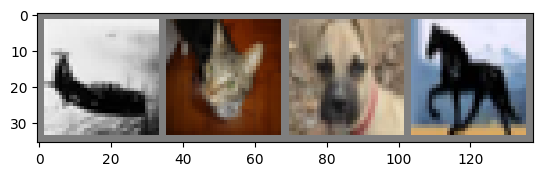

plane cat   dog   horse


In [21]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader1)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## Merging the Models

The merge_two_models function defines the process of merging two models. The parameters of both models are averaged with a weighted factor (alpha). Adjusting this factor allows experimentation with the degree of influence each model has on the merged model. The resulting merged model is then tested on the CIFAR-10 test dataset.

In [ ]:
# Setup
def merge_two_models(model1, model2, a):
    sd1 = model1.state_dict()
    sd2 = model2.state_dict()

    # # Average all parameters
    # for key in sd1:
    #     sd2[key] = (sd2[key] + sd1[key]) / 2.

    alpha = a  # Experiment with different values - 1.0 = 75%
    for key in sd1:
        sd2[key] = alpha * sd2[key] + (1 - alpha) * sd1[key]

    # Recreate model and load averaged state_dict (or use modelA/B)
    m = Net()
    m.load_state_dict(sd2)

    return m

## Testing the Models

Okay, first step. Let us display an image from the test set to get familiar.

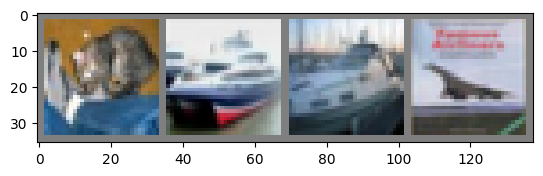

GroundTruth:  cat   ship  ship  plane


In [23]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
test(model1, testloader)
test(model2, testloader)

Accuracy of the network on the 10000 test images: 73 %
Accuracy of the network on the 10000 test images: 74 %


In [29]:
# import random
# alphas = []

# for _ in range(10):
#     alphas.append(round(random.uniform(0, 3), 2))

# for a in alphas:
#   model = merge_two_models(model1, model2, a)
#   test(model, testloader), print(f" - {a}")

model = merge_two_models(model1, model2, 1.033)
test(model, testloader)

Accuracy of the network on the 10000 test images: 73 %


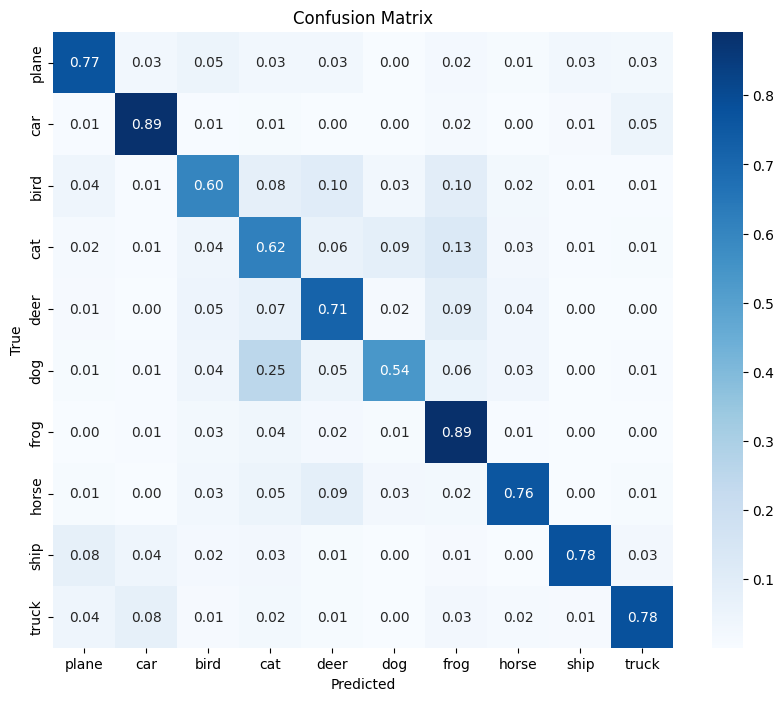

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(model, testloader, classes):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Plot confusion matrix for model1
plot_confusion_matrix(model1, testloader, classes)

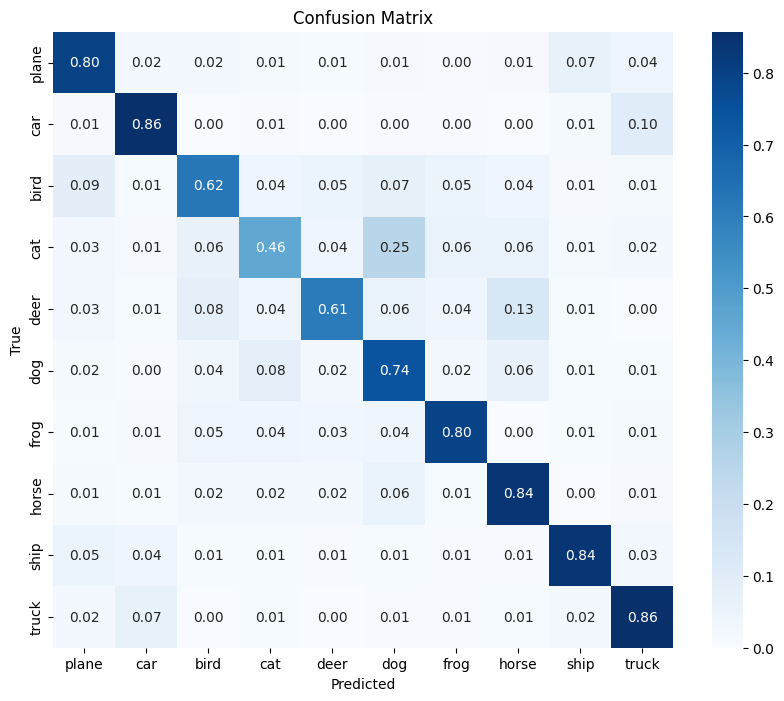

In [32]:
# Plot confusion matrix for model2
plot_confusion_matrix(model2, testloader, classes)

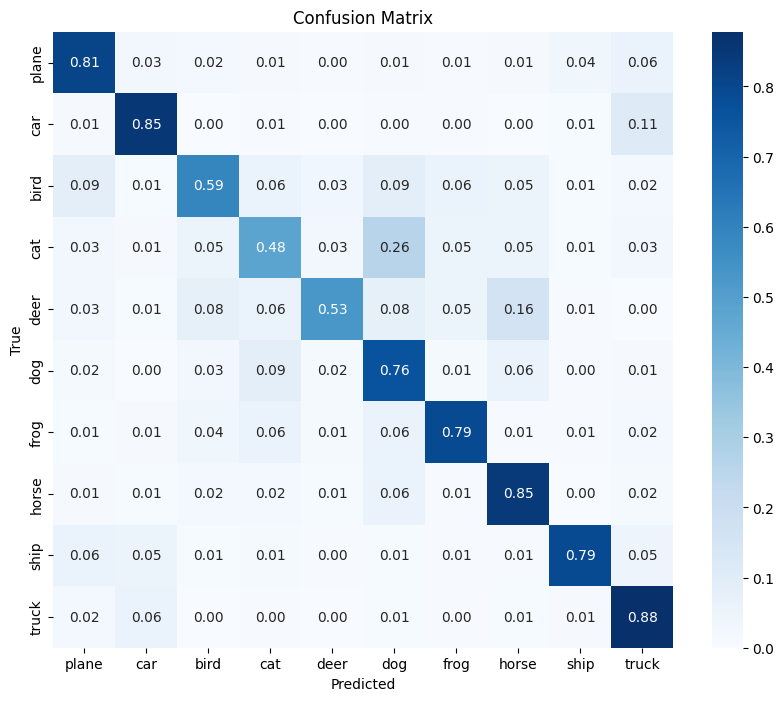

In [31]:
# Plot confusion matrix for the merged model
plot_confusion_matrix(model, testloader, classes)

## Conclusion

This project showcases the training of independent CNN models and their subsequent merging using federated learning. The effectiveness of the federated learning approach is evaluated by testing the individual models and the merged model on the CIFAR-10 test dataset. Adjusting the merging parameters provides flexibility to explore different collaborative learning strategies.